# Data preparation and training and using $K$-means

In [1]:
#Import data and take out prostitution data
import pandas as pd
SFPD = pd.read_csv('SFPD_Incidents.csv')
date = [int(i.split('/')[-1]) for i in SFPD['Date']]
SFPD['Year']=date
data = SFPD.loc[SFPD['Category'].isin(['PROSTITUTION'])]

We now want to convert our data so we have total amount of prostitution, vehicle theft, and total amount for each district. Note that this is retrieved from the full SFPD data set.

In [2]:
a2003=SFPD[SFPD.Year==2003].loc[SFPD['Category'].isin(['PROSTITUTION'])]['PdDistrict'].value_counts()
b2003=SFPD[SFPD.Year==2003].loc[SFPD['Category'].isin(['VEHICLE THEFT'])]['PdDistrict'].value_counts()
c2003=SFPD[SFPD.Year==2003]['PdDistrict'].value_counts()
a2015=SFPD[SFPD.Year==2015].loc[SFPD['Category'].isin(['PROSTITUTION'])]['PdDistrict'].value_counts()
b2015=SFPD[SFPD.Year==2015].loc[SFPD['Category'].isin(['VEHICLE THEFT'])]['PdDistrict'].value_counts()
c2015=SFPD[SFPD.Year==2015]['PdDistrict'].value_counts()
    
    

Formatting to dataframe

In [3]:
data_scatter2003=pd.DataFrame()
data_scatter2015=pd.DataFrame()

data_scatter2003['X']=a2003
data_scatter2015['X']=a2015
data_scatter2003['Y']=b2003
data_scatter2015['Y']=b2015
data_scatter2003['Z']=c2003
data_scatter2015['Z']=c2015
data_scatter2003['District']=data_scatter2003.index.values
data_scatter2015['District']=data_scatter2015.index.values

Saving to JSON

In [4]:
data_scatter2003.to_json('scatter2003.json', orient = "values")
data_scatter2015.to_json('scatter2015.json', orient = "values")

We remove everything except prostitution and remove the the outliers.

In [5]:
data_lonlat = data[['X','Y']]
data_lonlat = data_lonlat.loc[data_lonlat['Y']<85]


In [6]:
data_lonlat.to_json('./coords.json',orient = 'values')

## $K$-Means

We prepare the data for $K$-means in a Numpy matrix with data in columns.

In [7]:
import numpy as np
X =  np.matrix([data_lonlat['X'],data_lonlat['Y']]).T

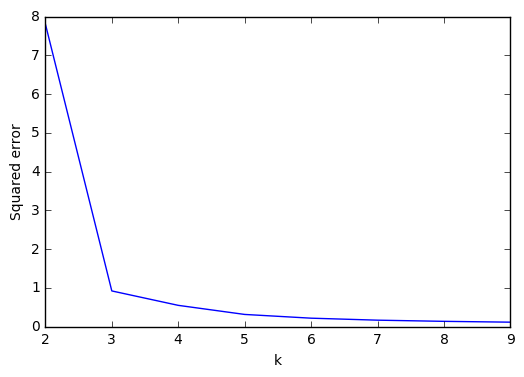

In [8]:
from sklearn.cluster import KMeans
import geoplotlib as gpl
import matplotlib.pyplot as plt
%matplotlib inline

# Take out prostitution for visualization
data = SFPD.loc[SFPD['Category'].isin(['PROSTITUTION'])]
# remove f'ed up data points
data = data.loc[data['Y'] < 85]

# Take out relevant columns for plotting
plot_data = data[['Category','X','Y']]
# Rename columns for geoplotlib
plot_data.columns = ['Category','lon','lat']
plot_data_d = {'lon': plot_data['lon'].tolist(), 'lat' : plot_data['lat'].tolist()}

# Put data in numpy matrix and transpose
X = np.matrix([plot_data_d['lon'], plot_data_d['lat']]).T

#Train KMeans model
def trainKmeans(nClusters, X):
    KM = KMeans(nClusters)
    KM.fit(X)
    return KM

# Calculate the squared error of the training data
def sqError(KM):
    return np.square(KM.inertia_)

# Train models and plot squared error
def plotSqError(X):
    sqErs = []
    for i in range(2,10):
        # Train K means
        KM = trainKmeans(i, X)
        sqErs.append(sqError(KM))
    plt.plot(range(2,10), sqErs)
    plt.xticks(range(2,10))
    plt.xlabel("k")
    plt.ylabel("Squared error")
    
plotSqError(X)

# Train for K = 3
KM = trainKmeans(3, X)
KM_d = {'lon' : KM.cluster_centers_[:, 0], 'lat' : KM.cluster_centers_[:, 1]}

# Plot results using Geoplotlib
gpl.dot(plot_data_d)
gpl.dot(KM_d, color=[0,0,255])
gpl.set_bbox(gpl.utils.BoundingBox(north=37.83, south=37.639830, east=-123, west=-122))
gpl.inline()


In [9]:
# Save results of training K-means with different K's in a pandas dataframe for exporting to JSON.
df=pd.DataFrame()
for i in range(2,7):
    KM = trainKmeans(i,X)
    df["K%d" % i]=KM.labels_
    cf = pd.DataFrame()
    cf['ccx']=KM.cluster_centers_[:, 0]
    cf['ccy']=KM.cluster_centers_[:, 1]
    cf.to_json('./center%d.json' % i, orient = "values")
    
# Export labels of datapoints to JSON for later coloring with D3.js
df.to_json('./labels.json',orient = "values")